# Inferential Statistics Ib - Frequentism

## Learning objectives

Welcome to the second Frequentist inference mini-project! Over the course of working on this mini-project and the previous frequentist mini-project, you'll learn the fundamental concepts associated with frequentist inference. The following list includes the topics you will become familiar with as you work through these two mini-projects:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

## Prerequisites

* what a random variable is
* what a probability density function (pdf) is
* what the cumulative density function is
* a high-level sense of what the Normal distribution

If these concepts are new to you, please take a few moments to Google these topics in order to get a sense of what they are and how you might use them.

These two notebooks were designed to bridge the gap between having a basic understanding of probability and random variables and being able to apply these concepts in Python. This second frequentist inference mini-project focuses on a real-world application of this type of inference to give you further practice using these concepts. 

In the previous notebook, we used only data from a known normal distribution. You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.

## Hospital medical charges

Imagine that a hospital has hired you as their data analyst. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. This mini-project, as well as the bootstrap and Bayesian inference mini-projects also found in this unit are designed to illustrate how each of the inferential statistics methods have their uses for different use cases. In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?
Answering that last question with a frequentist approach makes some assumptions, or requires some knowledge, about the two groups. In the next mini-project, you'll use bootstrapping to test that assumption. And in the final mini-project of the unit, you're going to create a model for simulating _individual_ charges (not a sampling distribution) that the hospital can use to model a range of scenarios.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). For the purposes of this exercise, assume the observations are the result of random sampling from our one hospital. Recall in the previous assignment, we introduced the Central Limit Theorem (CLT), and how it tells us that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data. Remember, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed
medical = pd.read_csv('data/insurance2.csv')

### 1) Exploring the Data Distribution

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__ We get the mean 13270.42 and standard deviation of 12105.48 for charges from our sample data. Along with the statistics, we plot the distribution of the charges, and position the vertical lines of mean, $\sigma$ and $2\sigma$. It is obvious that the charge distribution is non-normal, it's right-skewed. And the mean will be centered in where the data most at, the mean and standard deviation will not be the most appropriate statistics to describe the data. Hence, we will compute the median, and quantile percentile for the data, along with the cumulative density plot.

In [4]:
# Mean of the sample
charges_mean = round(np.mean(medical.charges),2)
print('Mean of Medical Charges: {}'.format(charges_mean))

# Standard deviation of the sample
charges_std = round(np.std(medical.charges), 2)
print('Standard Deviation of Medical Charges: {}'.format(charges_std))

Mean of Medical Charges: 13270.42
Standard Deviation of Medical Charges: 12105.48


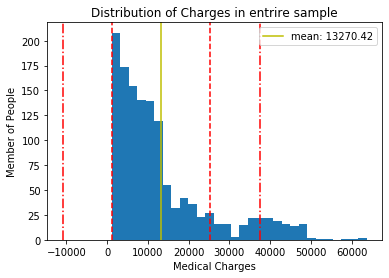

In [5]:
# Plot the distribution of the medical charges

_ = plt.hist(medical.charges, bins=30)
_ = plt.xlabel('Medical Charges')
_ = plt.ylabel('Member of People')
_ = plt.title('Distribution of Charges in entrire sample')
_ = plt.axvline(charges_mean, color='y', label = str('mean: 13270.42' ))
_ = plt.axvline(charges_mean+charges_std, color='r', linestyle='--')
_ = plt.axvline(charges_mean-charges_std, color='r', linestyle='--')
_ = plt.axvline(charges_mean+2*charges_std, color='r', linestyle='-.')
_ = plt.axvline(charges_mean-2*charges_std, color='r', linestyle='-.')
_ = plt.legend(loc = 'upper right')
plt.show()

In [6]:
# print the median
charges_median = np.median(medical.charges)
print('Median of Medical Charges: {}'.format(charges_median))

# print the quantile percentile 
charge_quantile  = pd.DataFrame(medical.charges.describe())[3:]
print('Quantile description of Charges:\n', charge_quantile)

Median of Medical Charges: 9382.033
Quantile description of Charges:
           charges
min   1121.873900
25%   4740.287150
50%   9382.033000
75%  16639.912515
max  63770.428010


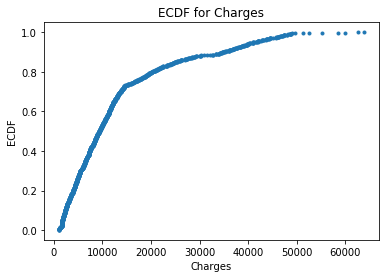

In [7]:
# define the empirical cdf function
def ecdf(data):
    #number of data points
    n = len(data)
    # x data for ecdf
    x = np.sort(data)
    # y data for ecdf
    y = np.arange(1, n+1)/n
    
    return x, y


# Applye the ecdf to data
x_charges, y_charges = ecdf(medical.charges)
# plot the ecdf for charges
_ = plt.plot(x_charges, y_charges, marker = '.', linestyle = 'none')

# plot the data
# Label the axes
_ = plt.xlabel('Charges')
_ = plt.ylabel('ECDF')
_ = plt.title('ECDF for Charges')

# Display the plot
plt.show()

Combined with the description, the 50% of the charges are below 9382.03, 75% of the charges lie below 16639.91.

<br/><br>

### 2) Frequentist Test - Confidence Interval

__Q:__ The administrator is concerned that the actual average charge has fallen below 12000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ Our sample data has 50% of the charges lie below 9382.03. However, the sample has a large proportion of patients with extremely high-paying, so the mean of the sample is 13270.42. In order to invesigate whether the average actual charge has fallen below 12000, we are planning to make some inference about the population based on our sample using sampling distribution.
<br/><br/>
As Noted here, our sample size $n$ = 1338 is fairly large then our sampling distribution will be a good approximate to the normal distribution.
<br/><br/>
Both $t$ statistic and $z$ statistic are considered valid in this situation. $t$ statistic has tolerance for relatively small sample size (e.g <30) and when the population parameter is unknown. Given our situation we have no access to the population parameters, we will use $t$ statistic to to complete pur frequentist test.

__Q:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A one-sided or two-sided interval? Calculate the critical value and the relevant 95% confidence interval for the mean and comment on whether the administrator should be concerned?

__A:__ We will use $t$ statistic to calculate the confidence interval here. Actually a one-sided interval would be enough  we will compare the left bound of the 95% confidence interval for the mean with the value 12000 to see if there's overlapping.

#### Using $t$ statistic:

In [11]:
# estimate the sampling distribution
estimated_mean = (charges_mean)
estimated_std = np.std(medical.charges, ddof = 1)
crit_val = t.ppf(.95, len(medical.charges)-1)
std_err = estimated_std/np.sqrt(len(medical.charges))
marg_err = crit_val*std_err
con_int = [estimated_mean - marg_err, estimated_mean + marg_err]

# print the condidence level we estimate
print("mean:", estimated_mean)
print("standard deviation:", estimated_std)
print("standard error:", std_err)
print("critical value:", crit_val)
print("margin of error:", marg_err)
print("confidence interval",con_int)

mean: 13270.42
standard deviation: 12110.011236693994
standard error: 331.06745431568226
critical value: 1.6459941145571317
margin of error: 544.9350813250251
confidence interval [12725.484918674974, 13815.355081325026]


__Conclusion__ : The relevant 95% confidence interval for the mean is [12725.48, 13815.35], which means that we are 95% confidence that our population mean are fall in this range. We also see the left boundary are 12725.48 > 12000, so there's no concern that the average actual charge has fallen below 12000.

<br/><br/>

### 3) T-Test on Two Independent Samples

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means where the pooled standard deviation of the two groups is given by
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t* test statistic is then given by

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

What assumption about the variances of the two groups are we making here?

<br/><br/>
__A:__ To use the t-test on two independent samples, we assume the two groups have equal variance.
<br/><br/>
H_0: $\mu$_A = $\mu$_B, the average of people with insurance are equal to the average of those without insurance.
<br/><br/>
H_A:  $\mu$_A ≠ $\mu$_B, the average of people with insurance are not equal to the average of those without insurance.
<br/><br/>

__Q:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

#### Perform this hypothesis test manually

In [68]:
# define the function 

def two_sample_ttest(data0, data1):
    mean0, mean1 = np.mean(data0), np.mean(data1)
    var0, var1 = np.var(data0), np.var(data1)
    n0, n1 = len(data0), len(data1)
    S_p = np.sqrt(((n0-1)*var0 + (n1-1)*var1)/(n0 + n1 - 2))
    t_stats = (mean0-mean1)/(S_p*np.sqrt(1/n0 + 1/n1))
    P_value = 2 * (1 - t.cdf(np.abs(t_stats),(n0 + n1-2)))
    return t_stats, P_value

In [69]:
two_sample_ttest(medical.charges[medical.insuranceclaim==1],medical.charges[medical.insuranceclaim==0])

(11.901306943555385, 0.0)

#### Perform this hypothesis test with `scipy.stats`

In [77]:
stats.ttest_ind(medical.charges[medical.insuranceclaim==1],
                medical.charges[medical.insuranceclaim==0])

Ttest_indResult(statistic=11.893299030876712, pvalue=4.461230231620717e-31)

__Conclusion__: We can see both the manually computing and the `scipy.stats` module returns the same results with very small p value, we conclude that if the average charges between the two group are the same, it's highly unlikely to observe the as least different values as we did in our sample, hence we reject the null hypothesis and accept the average mean are different for groups with and without insurance.

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do pass your data to it.

### 4) Equal Variance 
<br/>
We can specify the `equal_var` argument for `stats.ttest_ind` function.
<br>
If True (default), perform a standard independent 2 sample test that assumes equal population variances. If False, perform Welch’s t-test, which does not assume equal population variance.

__Q:__ In the above calculations, we assumed the sample variances were equal. We may well suspect they are not (we'll explore this in another assignment). The calculation becomes a little more complicated to do by hand in this case, but we now know of a helpful function. Check the documentation for the function to tell it not to assume equal variances and perform the test again.

__A:__ Let's specify the test without assumption of equal variance.

In [78]:
stats.ttest_ind(medical.charges[medical.insuranceclaim ==1],
                medical.charges[medical.insuranceclaim ==1],
                equal_var= False)

Ttest_indResult(statistic=0.0, pvalue=1.0)

__Q:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ There's no an equivalent one for performing a z-test on our sample.

In [80]:
print(stats.__doc__)


Statistical functions (:mod:`scipy.stats`)

.. currentmodule:: scipy.stats

This module contains a large number of probability distributions as
well as a growing library of statistical functions.

Each univariate distribution is an instance of a subclass of `rv_continuous`
(`rv_discrete` for discrete distributions):

.. autosummary::
   :toctree: generated/

   rv_continuous
   rv_discrete
   rv_histogram

Continuous distributions

.. autosummary::
   :toctree: generated/

   alpha             -- Alpha
   anglit            -- Anglit
   arcsine           -- Arcsine
   argus             -- Argus
   beta              -- Beta
   betaprime         -- Beta Prime
   bradford          -- Bradford
   burr              -- Burr (Type III)
   burr12            -- Burr (Type XII)
   cauchy            -- Cauchy
   chi               -- Chi
   chi2              -- Chi-squared
   cosine            -- Cosine
   crystalball       -- Crystalball
   dgamma            -- Double Gamma
   dweibull          -

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test